In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from tqdm import tqdm
from dataclasses import dataclass

In [8]:
@dataclass
class FDTDAlignedParams:
    sigma_y_Dx: any
    sigma_z_Dy: any
    sigma_x_Dz: any
    sigma_z_Ex: any
    sigma_x_Ex: any
    epsilon_Ex: any
    sigma_x_Ey: any
    sigma_y_Ey: any
    epsilon_Ey: any
    sigma_y_Ez: any
    sigma_z_Ez: any
    epsilon_Ez: any
    sigma_y_Bx: any
    sigma_z_By: any
    sigma_x_Bz: any
    sigma_z_Hx: any
    sigma_x_Hx: any
    mu_Hx: any
    sigma_x_Hy: any
    sigma_y_Hy: any
    mu_Hy: any
    sigma_y_Hz: any
    sigma_z_Hz: any
    mu_Hz: any

class fdtd_functions:
    @staticmethod
    def gaussian_source(n, dt, sigma, omega0):
        t_now = (n - 0.5) * dt
        t0 = 4 * sigma
        return cp.exp(-((t_now - t0) / sigma) ** 2) * cp.sin(omega0 * (t_now - t0))

    @staticmethod
    def sigma_profile(sigma_max, pml_thickness, distance):
        return sigma_max * (distance / pml_thickness) ** 3

    @staticmethod
    def pml_profile(sigma_max, pml_thickness, Nx, Ny, Nz):
        sigma_x = cp.zeros(Nx)
        sigma_y = cp.zeros(Ny)
        sigma_z = cp.zeros(Nz)
        for i in range(pml_thickness):
            sigma_x[i] = fdtd_functions.sigma_profile(sigma_max, pml_thickness, pml_thickness - i)
            sigma_x[-1 - i] = fdtd_functions.sigma_profile(sigma_max, pml_thickness, pml_thickness - i)
        for j in range(pml_thickness):
            sigma_y[j] = fdtd_functions.sigma_profile(sigma_max, pml_thickness, pml_thickness - j)
            sigma_y[-1 - j] = fdtd_functions.sigma_profile(sigma_max, pml_thickness, pml_thickness - j)
        for k in range(pml_thickness):
            sigma_z[k] = fdtd_functions.sigma_profile(sigma_max, pml_thickness, pml_thickness - k)
            sigma_z[-1 - k] = fdtd_functions.sigma_profile(sigma_max, pml_thickness, pml_thickness - k)
        return sigma_x, sigma_y, sigma_z

    @staticmethod
    def fdtd_param_alignment(Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz,sigma_x_3d, sigma_y_3d, sigma_z_3d, epsilon, mu):
        # Dx
        sigma_y_Dx = cp.zeros_like(Dx, dtype = cp.float32)
        sigma_y_Dx[1:-1, :, :] = 0.5 * (sigma_y_3d[:-1, :, :] + sigma_y_3d[1:, :, :])
        sigma_y_Dx[0, :, :] = sigma_y_3d[0, :, :]
        sigma_y_Dx[-1, :, :] = sigma_y_3d[-1, :, :]
        # Dy
        sigma_z_Dy = cp.zeros_like(Dy, dtype = cp.float32)
        sigma_z_Dy[:, 1:-1, :] = 0.5 * (sigma_z_3d[:, :-1, :] + sigma_z_3d[:, 1:, :])
        sigma_z_Dy[:, 0, :] = sigma_z_3d[:, 0, :]
        sigma_z_Dy[:, -1, :] = sigma_z_3d[:, -1, :]

        # Dz
        sigma_x_Dz = cp.zeros_like(Dz, dtype = cp.float32)
        sigma_x_Dz[:, :, 1:-1] = 0.5 * (sigma_x_3d[:, :, :-1] + sigma_x_3d[:, :, 1:])
        sigma_x_Dz[:, :, 0] = sigma_x_3d[:, :, 0]
        sigma_x_Dz[:, :, -1] = sigma_x_3d[:, :, -1]

        # Ex
        sigma_z_Ex = cp.zeros_like(Ex, dtype = cp.float32)
        sigma_z_Ex[1:-1, :, :] = 0.5 * (sigma_z_3d[:-1, :, :] + sigma_z_3d[1:, :, :])
        sigma_z_Ex[0, :, :] = sigma_z_3d[0, :, :]
        sigma_z_Ex[-1, :, :] = sigma_z_3d[-1, :, :]

        sigma_x_Ex = cp.zeros_like(Ex, dtype = cp.float32)
        sigma_x_Ex[1:-1, :, :] = 0.5 * (sigma_x_3d[:-1, :, :] + sigma_x_3d[1:, :, :])
        sigma_x_Ex[0, :, :] = sigma_x_3d[0, :, :]
        sigma_x_Ex[-1, :, :] = sigma_x_3d[-1, :, :]

        epsilon_Ex = cp.zeros_like(Ex, dtype = cp.float32)
        epsilon_Ex[1:-1, :, :] = 0.5 * (epsilon[:-1, :, :] + epsilon[1:, :, :])
        epsilon_Ex[0, :, :] = epsilon[0, :, :]
        epsilon_Ex[-1, :, :] = epsilon[-1, :, :]

        # Ey
        sigma_x_Ey = cp.zeros_like(Ey, dtype = cp.float32)
        sigma_x_Ey[:, 1:-1, :] = 0.5 * (sigma_x_3d[:, :-1, :] + sigma_x_3d[:, 1:, :])
        sigma_x_Ey[:, 0, :] = sigma_x_3d[:, 0, :]
        sigma_x_Ey[:, -1, :] = sigma_x_3d[:, -1, :]

        sigma_y_Ey = cp.zeros_like(Ey, dtype = cp.float32)
        sigma_y_Ey[:, 1:-1, :] = 0.5 * (sigma_y_3d[:, :-1, :] + sigma_y_3d[:, 1:, :])
        sigma_y_Ey[:, 0, :] = sigma_y_3d[:, 0, :]
        sigma_y_Ey[:, -1, :] = sigma_y_3d[:, -1, :]

        epsilon_Ey = cp.zeros_like(Ey, dtype = cp.float32)
        epsilon_Ey[:, 1:-1, :] = 0.5 * (epsilon[:, :-1, :] + epsilon[:, 1:, :])
        epsilon_Ey[:, 0, :] = epsilon[:, 0, :]
        epsilon_Ey[:, -1, :] = epsilon[:, -1, :]

        # Ez
        sigma_y_Ez = cp.zeros_like(Ez, dtype = cp.float32)
        sigma_y_Ez[:, :, 1:-1] = 0.5 * (sigma_y_3d[:, :, :-1] + sigma_y_3d[:, :, 1:])
        sigma_y_Ez[:, :, 0] = sigma_y_3d[:, :, 0]
        sigma_y_Ez[:, :, -1] = sigma_y_3d[:, :, -1]

        sigma_z_Ez = cp.zeros_like(Ez, dtype = cp.float32)
        sigma_z_Ez[:, :, 1:-1] = 0.5 * (sigma_z_3d[:, :, :-1] + sigma_z_3d[:, :, 1:])
        sigma_z_Ez[:, :, 0] = sigma_z_3d[:, :, 0]
        sigma_z_Ez[:, :, -1] = sigma_z_3d[:, :, -1]

        epsilon_Ez = cp.zeros_like(Ez, dtype = cp.float32)
        epsilon_Ez[:, :, 1:-1] = 0.5 * (epsilon[:, :, :-1] + epsilon[:, :, 1:])
        epsilon_Ez[:, :, 0] = epsilon[:, :, 0]
        epsilon_Ez[:, :, -1] = epsilon[:, :, -1]
        # Bx
        sigma_y_Bx = cp.zeros_like(Bx, dtype = cp.float32)
        sigma_y_Bx[:, 1:-1, 1:-1] = 0.25 * (
                sigma_y_3d[:, :-1, :-1] + sigma_y_3d[:, 1:, :-1] + sigma_y_3d[:, :-1,
                                                                   1:] + sigma_y_3d[:, 1:, 1:])
        sigma_y_Bx[:, 0, :] = sigma_y_Bx[:, 1, :]
        sigma_y_Bx[:, -1, :] = sigma_y_Bx[:, -2, :]
        sigma_y_Bx[:, :, 0] = sigma_y_Bx[:, :, 1]
        sigma_y_Bx[:, :, -1] = sigma_y_Bx[:, :, -2]
        # By
        sigma_z_By = cp.zeros_like(By, dtype = cp.float32)
        sigma_z_By[1:-1, :, 1:-1] = 0.25 * (
                sigma_z_3d[:-1, :, :-1] + sigma_z_3d[1:, :, :-1] + sigma_z_3d[:-1, :,
                                                                   1:] + sigma_z_3d[1:, :, 1:])
        sigma_z_By[0, :, :] = sigma_z_By[1, :, :]
        sigma_z_By[-1, :, :] = sigma_z_By[-2, :, :]
        sigma_z_By[:, :, 0] = sigma_z_By[:, :, 1]
        sigma_z_By[:, :, -1] = sigma_z_By[:, :, -2]

        # Bz
        sigma_x_Bz = cp.zeros_like(Bz, dtype = cp.float32)
        sigma_x_Bz[1:-1, 1:-1, :] = 0.25 * (
                sigma_x_3d[:-1, :-1, :] + sigma_x_3d[1:, :-1, :] + sigma_x_3d[:-1, 1:,
                                                                   :] + sigma_x_3d[1:, 1:, :])
        sigma_x_Bz[0, :, :] = sigma_x_Bz[1, :, :]
        sigma_x_Bz[-1, :, :] = sigma_x_Bz[-2, :, :]
        sigma_x_Bz[:, 0, :] = sigma_x_Bz[:, 1, :]
        sigma_x_Bz[:, -1, :] = sigma_x_Bz[:, -2, :]

        # Hx
        sigma_z_Hx = cp.zeros_like(Hx, dtype = cp.float32)
        sigma_z_Hx[:, 1:-1, 1:-1] = 0.25 * (
                    sigma_z_3d[:, :-1, :-1] + sigma_z_3d[:, 1:, :-1] + sigma_z_3d[:, :-1,
                                                                       1:] + sigma_z_3d[:, 1:, 1:])
        sigma_z_Hx[:, 0, :] = sigma_z_Hx[:, 1, :]
        sigma_z_Hx[:, -1, :] = sigma_z_Hx[:, -2, :]
        sigma_z_Hx[:, :, 0] = sigma_z_Hx[:, :, 1]
        sigma_z_Hx[:, :, -1] = sigma_z_Hx[:, :, -2]

        sigma_x_Hx = cp.zeros_like(Hx, dtype = cp.float32)
        sigma_x_Hx[:, 1:-1, 1:-1] = 0.25 * (
                    sigma_x_3d[:, :-1, :-1] + sigma_x_3d[:, 1:, :-1] + sigma_x_3d[:, :-1,
                                                                       1:] + sigma_x_3d[:, 1:, 1:])
        sigma_x_Hx[:, 0, :] = sigma_x_Hx[:, 1, :]
        sigma_x_Hx[:, -1, :] = sigma_x_Hx[:, -2, :]
        sigma_x_Hx[:, :, 0] = sigma_x_Hx[:, :, 1]
        sigma_x_Hx[:, :, -1] = sigma_x_Hx[:, :, -2]
        mu_Hx = cp.zeros_like(Hx, dtype = cp.float32)
        mu_Hx[:, 1:-1, 1:-1] = 0.25 * (
                    mu[:, :-1, :-1] + mu[:, 1:, :-1] + mu[:, :-1, 1:] + mu[:, 1:, 1:])
        mu_Hx[:, 0, :] = mu_Hx[:, 1, :]
        mu_Hx[:, -1, :] = mu_Hx[:, -2, :]
        mu_Hx[:, :, 0] = mu_Hx[:, :, 1]
        mu_Hx[:, :, -1] = mu_Hx[:, :, -2]

        # Hy
        sigma_x_Hy = cp.zeros_like(Hy, dtype = cp.float32)
        sigma_x_Hy[1:-1, :, 1:-1] = 0.25 * (
                    sigma_x_3d[:-1, :, :-1] + sigma_x_3d[1:, :, :-1] + sigma_x_3d[:-1, :,
                                                                       1:] + sigma_x_3d[1:, :, 1:])
        sigma_x_Hy[0, :, :] = sigma_x_Hy[1, :, :]
        sigma_x_Hy[-1, :, :] = sigma_x_Hy[-2, :, :]
        sigma_x_Hy[:, :, 0] = sigma_x_Hy[:, :, 1]
        sigma_x_Hy[:, :, -1] = sigma_x_Hy[:, :, -2]

        sigma_y_Hy = cp.zeros_like(Hy, dtype = cp.float32)
        sigma_y_Hy[1:-1, :, 1:-1] = 0.25 * (
                    sigma_y_3d[:-1, :, :-1] + sigma_y_3d[1:, :, :-1] + sigma_y_3d[:-1, :,
                                                                       1:] + sigma_y_3d[1:, :, 1:])
        sigma_y_Hy[0, :, :] = sigma_y_Hy[1, :, :]
        sigma_y_Hy[-1, :, :] = sigma_y_Hy[-2, :, :]
        sigma_y_Hy[:, :, 0] = sigma_y_Hy[:, :, 1]
        sigma_y_Hy[:, :, -1] = sigma_y_Hy[:, :, -2]

        mu_Hy = cp.zeros_like(Hy, dtype = cp.float32)
        mu_Hy[1:-1, :, 1:-1] = 0.25 * (
                    mu[:-1, :, :-1] + mu[1:, :, :-1] + mu[:-1, :, 1:] + mu[1:, :, 1:])
        mu_Hy[0, :, :] = mu_Hy[1, :, :]
        mu_Hy[-1, :, :] = mu_Hy[-2, :, :]
        mu_Hy[:, :, 0] = mu_Hy[:, :, 1]
        mu_Hy[:, :, -1] = mu_Hy[:, :, -2]
        # Hz
        sigma_y_Hz = cp.zeros_like(Hz, dtype = cp.float32)
        sigma_y_Hz[1:-1, 1:-1, :] = 0.25 * (
                    sigma_y_3d[:-1, :-1, :] + sigma_y_3d[1:, :-1, :] + sigma_y_3d[:-1, 1:,
                                                                       :] + sigma_y_3d[1:, 1:, :])
        sigma_y_Hz[:, 0, :] = sigma_y_Hz[:, 1, :]
        sigma_y_Hz[:, -1, :] = sigma_y_Hz[:, -2, :]
        sigma_y_Hz[0, :, :] = sigma_y_Hz[1, :, :]
        sigma_y_Hz[-1, :, :] = sigma_y_Hz[-2, :, :]

        sigma_z_Hz = cp.zeros_like(Hz, dtype = cp.float32)
        sigma_z_Hz[1:-1, 1:-1, :] = 0.25 * (
                    sigma_z_3d[:-1, :-1, :] + sigma_z_3d[1:, :-1, :] + sigma_z_3d[:-1, 1:,
                                                                       :] + sigma_z_3d[1:, 1:, :])
        sigma_z_Hz[:, 0, :] = sigma_z_Hz[:, 1, :]
        sigma_z_Hz[:, -1, :] = sigma_z_Hz[:, -2, :]
        sigma_z_Hz[0, :, :] = sigma_z_Hz[1, :, :]
        sigma_z_Hz[-1, :, :] = sigma_z_Hz[-2, :, :]

        mu_Hz = cp.zeros_like(Hz, dtype = cp.float32)
        mu_Hz[1:-1, 1:-1, :] = 0.25 * (
                    mu[:-1, :-1, :] + mu[1:, :-1, :] + mu[:-1, 1:, :] + mu[1:, 1:, :])
        mu_Hz[:, 0, :] = mu_Hz[:, 1, :]
        mu_Hz[:, -1, :] = mu_Hz[:, -2, :]
        mu_Hz[0, :, :] = mu_Hz[1, :, :]
        mu_Hz[-1, :, :] = mu_Hz[-2, :, :]

        return FDTDAlignedParams(
            sigma_y_Dx, sigma_z_Dy, sigma_x_Dz,
            sigma_z_Ex, sigma_x_Ex, epsilon_Ex,
            sigma_x_Ey, sigma_y_Ey, epsilon_Ey,
            sigma_y_Ez, sigma_z_Ez, epsilon_Ez,
            sigma_y_Bx, sigma_z_By, sigma_x_Bz,
            sigma_z_Hx, sigma_x_Hx, mu_Hx,
            sigma_x_Hy, sigma_y_Hy, mu_Hy,
            sigma_y_Hz, sigma_z_Hz, mu_Hz
        )

    @staticmethod
    def update_equations(Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz,
                         Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old,
                         params:FDTDAlignedParams,
                         dt, dx, dy, dz):
        #     #unpack params
        sigma_y_Dx = params.sigma_y_Dx
        sigma_z_Dy = params.sigma_z_Dy
        sigma_x_Dz = params.sigma_x_Dz

        sigma_z_Ex = params.sigma_z_Ex
        sigma_x_Ex = params.sigma_x_Ex
        epsilon_Ex = params.epsilon_Ex
        sigma_x_Ey = params.sigma_x_Ey
        sigma_y_Ey = params.sigma_y_Ey
        epsilon_Ey = params.epsilon_Ey
        sigma_y_Ez = params.sigma_y_Ez
        sigma_z_Ez = params.sigma_z_Ez
        epsilon_Ez = params.epsilon_Ez
        sigma_y_Bx = params.sigma_y_Bx
        sigma_z_By = params.sigma_z_By
        sigma_x_Bz = params.sigma_x_Bz
        sigma_z_Hx = params.sigma_z_Hx
        sigma_x_Hx = params.sigma_x_Hx
        mu_Hx = params.mu_Hx
        sigma_x_Hy = params.sigma_x_Hy
        sigma_y_Hy = params.sigma_y_Hy
        mu_Hy = params.mu_Hy
        sigma_y_Hz = params.sigma_y_Hz
        sigma_z_Hz = params.sigma_z_Hz
        mu_Hz = params.mu_Hz

        Bx[1:-1, 1:-1, 1:-1] = ((1 - dt / 2 * sigma_y_Bx[1:-1, 1:-1, 1:-1]) / (1 + dt / 2 * sigma_y_Bx[1:-1, 1:-1, 1:-1])) * Bx[1:-1,
                                                                                         1:-1,
                                                                                         1:-1] + \
                               dt / (1 + dt / 2 * sigma_y_Bx[1:-1, 1:-1, 1:-1]) * (
                                       (Ey[1:-1, 1:-1, 1:] - Ey[1:-1, 1:-1, :-1]) / dz -
                                       (Ez[1:-1, 1:, 1:-1] - Ez[1:-1, :-1, 1:-1]) / dy
                               )

        By[1:-1, 1:-1, 1:-1] = ((1 - dt / 2 * sigma_z_By[1:-1, 1:-1, 1:-1]) / (1 + dt / 2 * sigma_z_By[1:-1, 1:-1, 1:-1])) * By[1:-1,
                                                                                         1:-1,
                                                                                         1:-1] + \
                               dt / (1 + dt / 2 * sigma_z_By[1:-1, 1:-1, 1:-1]) * (
                                       (Ez[1:, 1:-1, 1:-1] - Ez[:-1, 1:-1, 1:-1]) / dx -
                                       (Ex[1:-1, 1:-1, 1:] - Ex[1:-1, 1:-1, :-1]) / dz
                               )

        Bz[1:-1, 1:-1, 1:-1] = ((1 - dt / 2 * sigma_x_Bz[1:-1, 1:-1, 1:-1]) / (1 + dt / 2 * sigma_x_Bz[1:-1, 1:-1, 1:-1])) * Bz[1:-1,
                                                                                         1:-1,
                                                                                         1:-1] + \
                               dt / (1 + dt / 2 * sigma_x_Bz[1:-1, 1:-1, 1:-1]) * (
                                       (Ex[1:-1, 1:, 1:-1] - Ex[1:-1, :-1, 1:-1]) / dy -
                                       (Ey[1:, 1:-1, 1:-1] - Ey[:-1, 1:-1, 1:-1]) / dx
                               )


        Hx[1:-1, 1:-1, 1:-1] = (
                ((1 - dt / 2 * sigma_z_Hx[1:-1, 1:-1, 1:-1]) / (1 + dt / 2 * sigma_z_Hx[1:-1, 1:-1, 1:-1])) * Hx[1:-1, 1:-1,
                                                                                1:-1] +
                1 / (mu_Hx[1:-1, 1:-1, 1:-1] * (1 + dt / 2 * sigma_z_Hx[1:-1, 1:-1, 1:-1])) *
                (
                        (1 + dt / 2 * sigma_x_Hx[1:-1, 1:-1, 1:-1]) * Bx[1:-1, 1:-1, 1:-1] -
                        (1 - dt / 2 * sigma_x_Hx[1:-1, 1:-1, 1:-1]) * Bx_old[1:-1, 1:-1, 1:-1]
                )
        )

        Hy[1:-1, 1:-1, 1:-1] = (
                ((1 - dt / 2 * sigma_x_Hy[1:-1, 1:-1, 1:-1]) / (1 + dt / 2 * sigma_x_Hy[1:-1, 1:-1, 1:-1])) * Hy[1:-1, 1:-1,
                                                                                1:-1] +
                1 / (mu_Hy[1:-1, 1:-1, 1:-1] * (1 + dt / 2 * sigma_x_Hy[1:-1, 1:-1, 1:-1])) *
                (
                        (1 + dt / 2 * sigma_y_Hy[1:-1, 1:-1, 1:-1]) * By[1:-1, 1:-1, 1:-1] -
                        (1 - dt / 2 * sigma_y_Hy[1:-1, 1:-1, 1:-1]) * By_old[1:-1, 1:-1, 1:-1]
                )
        )

        Hz[1:-1, 1:-1, 1:-1] = (
                ((1 - dt / 2 * sigma_y_Hz[1:-1, 1:-1, 1:-1]) / (1 + dt / 2 * sigma_y_Hz[1:-1, 1:-1, 1:-1])) * Hz[1:-1, 1:-1,
                                                                                1:-1] +
                1 / (mu_Hz[1:-1, 1:-1, 1:-1] * (1 + dt / 2 * sigma_y_Hz[1:-1, 1:-1, 1:-1])) *
                (
                        (1 + dt / 2 * sigma_z_Hz[1:-1, 1:-1, 1:-1]) * Bz[1:-1, 1:-1, 1:-1] -
                        (1 - dt / 2 * sigma_z_Hz[1:-1, 1:-1, 1:-1]) * Bz_old[1:-1, 1:-1, 1:-1]
                )
        )

        
        Dx = ((1 - dt / 2 * sigma_y_Dx) / (1 + dt / 2 * sigma_y_Dx)) * Dx + \
                               dt / (1 + dt / 2 * sigma_y_Dx) * (
                                       (Hz[:, 1:, :] - Hz[:, :-1, :]) / (dy) -
                                       (Hy[:, :, 1:] - Hy[:, :, :-1]) / (dz)
                               )

        Dy = ((1 - dt / 2 * sigma_z_Dy) / (1 + dt / 2 * sigma_z_Dy)) * Dy + \
                               dt / (1 + dt / 2 * sigma_z_Dy) * (
                                       (Hx[:, :, 1:] - Hx[:, :, :-1]) / dz -
                                       (Hz[1:, :, :] - Hz[:-1, :, :]) / dx
                               )


        Dz = ((1 - dt / 2 * sigma_x_Dz) / (1 + dt / 2 * sigma_x_Dz)) * Dz + \
                               dt / (1 + dt / 2 * sigma_x_Dz) * (
                                       (Hy[1:, :, :] - Hy[:-1, :, :]) / dx -
                                       (Hx[:, 1:, :] - Hx[:, :-1, :]) / dy
                               )


        Ex = ((1 - dt / 2 * sigma_z_Ex) / (1 + dt / 2 * sigma_z_Ex)) * Ex + \
                               1 / (epsilon_Ex * (1 + dt / 2 * sigma_z_Ex)) * \
                               ((1 + dt / 2 * sigma_x_Ex) * Dx - (
                                       1 - dt / 2 * sigma_x_Ex) * Dx_old)

        Ey = ((1 - dt / 2 * sigma_x_Ey) / (1 + dt / 2 * sigma_x_Ey)) * Ey + \
                               1 / (epsilon_Ey * (1 + dt / 2 * sigma_x_Ey)) * \
                               ((1 + dt / 2 * sigma_y_Ey) * Dy - (
                                       1 - dt / 2 * sigma_y_Ey) * Dy_old)

        Ez = ((1 - dt / 2 * sigma_y_Ez) / (1 + dt / 2 * sigma_y_Ez)) * Ez + \
                               1 / (epsilon_Ez * (1 + dt / 2 * sigma_y_Ez)) * \
                               ((1 + dt / 2 * sigma_z_Ez) * Dz - (
                                       1 - dt / 2 * sigma_z_Ez) * Dz_old)

        Dx_old = cp.copy(Dx)
        Dy_old = cp.copy(Dy)
        Dz_old = cp.copy(Dz)
        Bx_old = cp.copy(Bx)
        By_old = cp.copy(By)
        Bz_old = cp.copy(Bz)

        return Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz, Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old

In [54]:
def plot_final_fields(Ex, Ey, Ez, Hx, Hy, Hz, Nx, Ny, Nz):
    kx = Nx // 2
    ky = Ny // 2
    kz = Nz // 2
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(Ex[kx, :, :], cmap='RdBu', origin='lower')
    plt.title('Ex at z = center')
    plt.colorbar()

    plt.subplot(2, 3, 2)
    plt.imshow(Ey[:, ky, :], cmap='RdBu', origin='lower')
    plt.title('Ey at z = center')
    plt.colorbar()

    plt.subplot(2, 3, 3)
    plt.imshow(Ez[:, :, kz], cmap='RdBu', origin='lower')
    plt.title('Ez at z = center')
    plt.colorbar()

    plt.subplot(2, 3, 4)
    plt.imshow(Hx[kx, :, :], cmap='RdBu', origin='lower')
    plt.title('Hx at z = center')
    plt.colorbar()

    plt.subplot(2, 3, 5)
    plt.imshow(Hy[:, ky, :], cmap='RdBu', origin='lower')
    plt.title('Hy at z = center')
    plt.colorbar()

    plt.subplot(2, 3, 6)
    plt.imshow(Hz[:, :, kz], cmap='RdBu', origin='lower')
    plt.title('Hz at z = center')
    plt.colorbar()
    
    plt.suptitle('Final field Distribution (z = center slice)')
    plt.tight_layout()
    plt.show()

def plot_probe_fields(t, Ex_record, Ey_record, Ez_record, Hx_record, Hy_record, Hz_record):
    plt.figure(figsize=(10, 6))
    plt.plot(t, Ex_record, label='Ex', linewidth=1.5)
    plt.plot(t, Ey_record, label='Ey', linewidth=3, linestyle='dotted')
    plt.plot(t, Ez_record, label='Ez', linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Electric Field at PML Inner Layer')
    plt.title('Electric Field vs Time at Probe Point')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(t, Hx_record, label='Hx', linewidth=1.5)
    plt.plot(t, Hy_record, label='Hy', linewidth=3, linestyle='dotted')
    plt.plot(t, Hz_record, label='Hz', linewidth=1.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Magnetic Field at PML Inner Layer')
    plt.title('Magnetic Field vs Time at Probe Point')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Main

2.998634


100%|██████████| 200/200 [00:01<00:00, 160.84it/s]


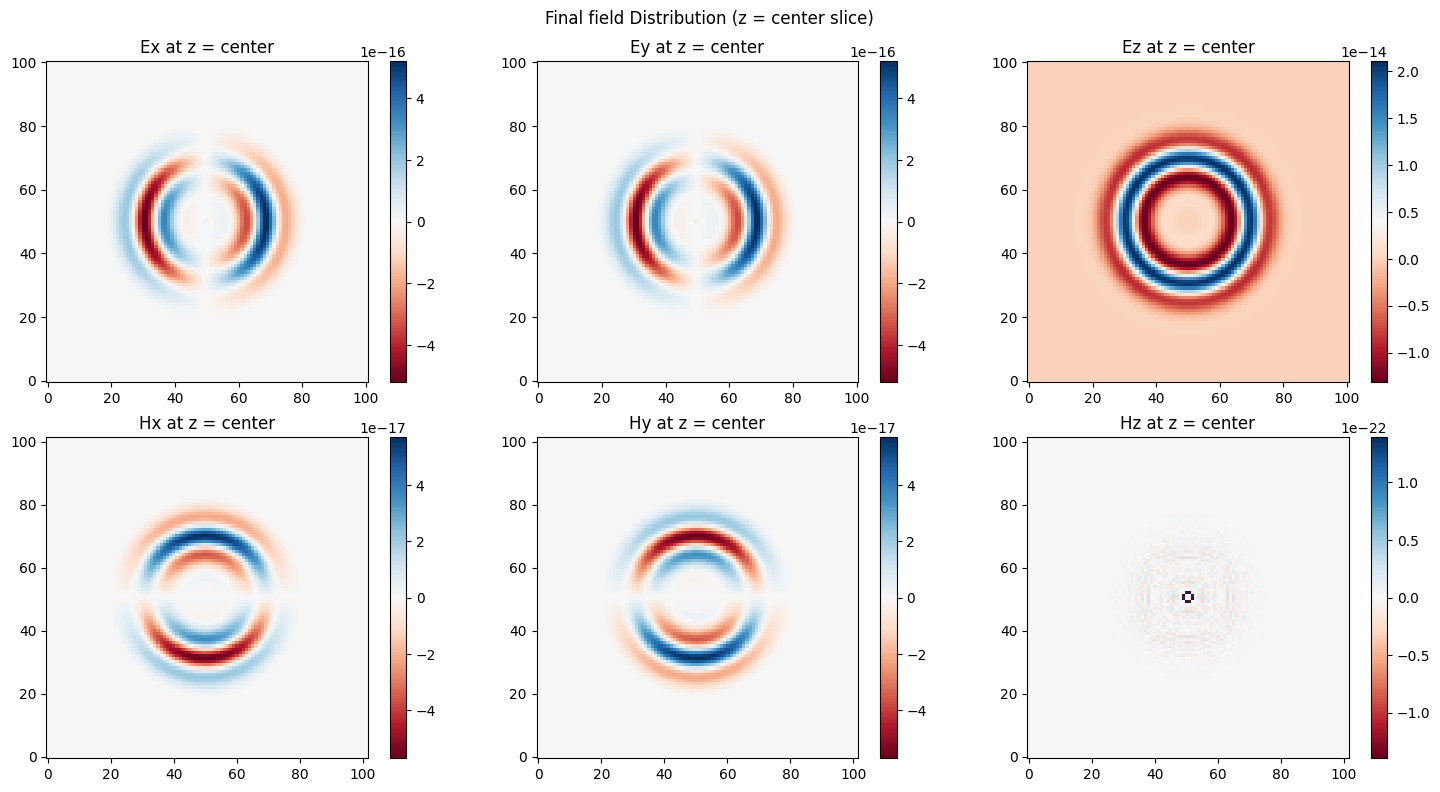

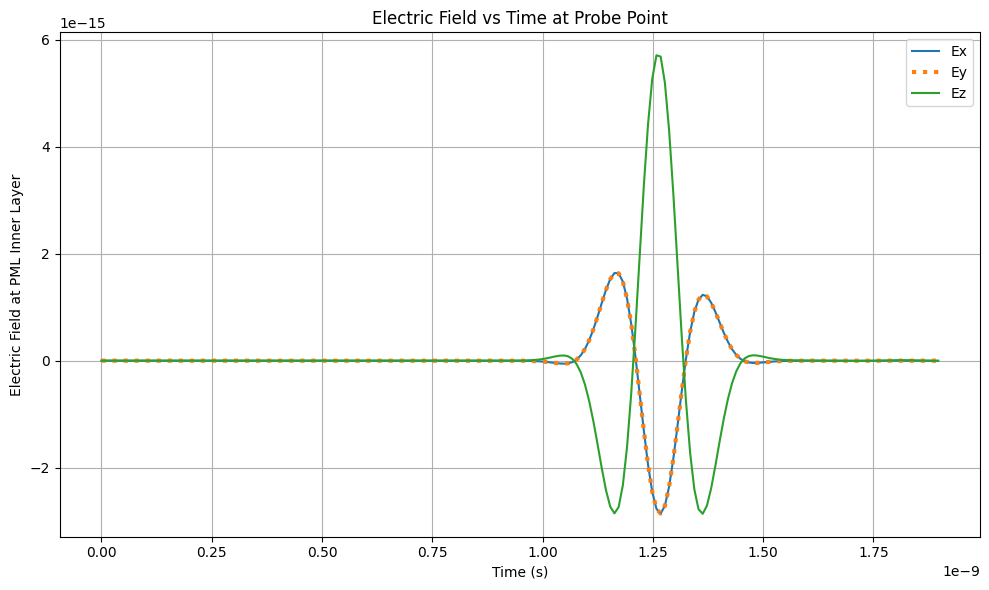

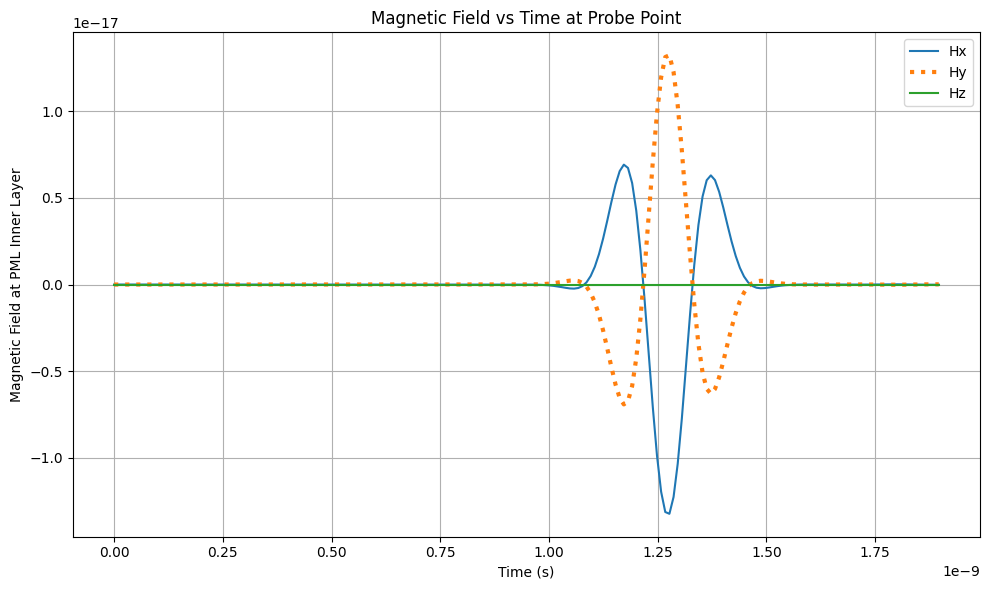

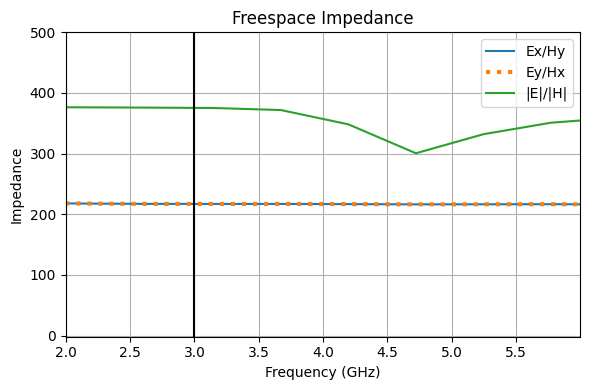

376.81943


In [55]:
def main():
    # Normalized
    # epsilon0 = cp.float32(1.0)
    # mu0 = cp.float32(1.0)
    # c0 = cp.float32(1.0)
    # sigma_max = 200

    # Not Normalized
    epsilon0 = cp.float32(8.85e-12)
    mu0 = cp.float32(4 * cp.pi * 1e-7)
    c0 = 1/cp.sqrt(epsilon0*mu0)
    # sigma_max = cp.float32(0.9e12) # without fixing J
    sigma_max = cp.float32(5e10) # fixed J

    pml_thickness = 16

    lambda_0 = cp.float32(100e-3)
    lambda_U = cp.float32(150e-3)
    lambda_L = cp.float32(50e-3)

    print(c0/lambda_0/1e9)

    dx = dy = dz = cp.float32(5e-3)  # m, spatial step size
    dt = 0.99 * dx / (c0 * cp.sqrt(cp.float32(3)))

    x_min, x_max = -250e-3, 250e-3
    y_min, y_max = -250e-3, 250e-3
    z_min, z_max = -250e-3, 250e-3

    Nx = int(round((x_max - x_min) / dx)) + 1
    Ny = int(round((y_max - y_min) / dy)) + 1
    Nz = int(round((z_max - z_min) / dz)) + 1

    nt = 200

    x_src, y_src, z_src = 0, 0, 0
    tmp = 5
    # x_prob, y_prob, z_prob = 0 + tmp * dx, 0 + tmp * dy, 0 + tmp * dz
    x_prob, y_prob, z_prob = x_min+(pml_thickness+tmp)*dx, y_min+(pml_thickness+tmp)*dy, z_min+(pml_thickness+tmp)*dz

    i_x_src = int(round((x_src - x_min) / dx))
    i_y_src = int(round((y_src - y_min) / dy))
    i_z_src = int(round((z_src - z_min) / dz))

    i_x_prob = int(round((x_prob - x_min) / dx))
    i_y_prob = int(round((y_prob - y_min) / dy))
    i_z_prob = int(round((z_prob - z_min) / dz))
    
    Ex_record = cp.zeros(nt, dtype = cp.float32)
    Ey_record = cp.zeros(nt, dtype = cp.float32)
    Ez_record = cp.zeros(nt, dtype = cp.float32)
    Hx_record = cp.zeros(nt, dtype = cp.float32)
    Hy_record = cp.zeros(nt, dtype = cp.float32)
    Hz_record = cp.zeros(nt, dtype = cp.float32)

    omega_0 = 2 * cp.pi * c0 / lambda_0
    sigma = (2 / omega_0) * (lambda_0 / (lambda_U - lambda_L))

    Ex = cp.zeros((Nx + 1, Ny, Nz), dtype = cp.float32)
    Ey = cp.zeros((Nx, Ny + 1, Nz), dtype = cp.float32)
    Ez = cp.zeros((Nx, Ny, Nz + 1), dtype = cp.float32)
    Hx = cp.zeros((Nx, Ny + 1, Nz + 1), dtype = cp.float32)
    Hy = cp.zeros((Nx + 1, Ny, Nz + 1), dtype = cp.float32)
    Hz = cp.zeros((Nx + 1, Ny + 1, Nz), dtype = cp.float32)
    Bx = cp.zeros((Nx, Ny + 1, Nz + 1), dtype = cp.float32)
    By = cp.zeros((Nx + 1, Ny, Nz + 1), dtype = cp.float32)
    Bz = cp.zeros((Nx + 1, Ny + 1, Nz), dtype = cp.float32)
    Dx = cp.zeros((Nx + 1, Ny, Nz), dtype = cp.float32)
    Dy = cp.zeros((Nx, Ny + 1, Nz), dtype = cp.float32)
    Dz = cp.zeros((Nx, Ny, Nz + 1), dtype = cp.float32)
    Bx_old = cp.zeros((Nx, Ny + 1, Nz + 1), dtype = cp.float32)
    By_old = cp.zeros((Nx + 1, Ny, Nz + 1), dtype = cp.float32)
    Bz_old = cp.zeros((Nx + 1, Ny + 1, Nz), dtype = cp.float32)
    Dx_old = cp.zeros((Nx + 1, Ny, Nz), dtype = cp.float32)
    Dy_old = cp.zeros((Nx, Ny + 1, Nz), dtype = cp.float32)
    Dz_old = cp.zeros((Nx, Ny, Nz + 1), dtype = cp.float32)
    epsilon = cp.ones((Nx, Ny, Nz), dtype = cp.float32) * epsilon0
    mu = cp.ones((Nx, Ny, Nz), dtype = cp.float32) * mu0

    sigma_x_vec, sigma_y_vec, sigma_z_vec = fdtd_functions.pml_profile(sigma_max, pml_thickness, Nx, Ny, Nz)
    sigma_x_3d, sigma_y_3d, sigma_z_3d = cp.meshgrid(sigma_x_vec, sigma_y_vec, sigma_z_vec,
                                                     indexing = 'ij')

    Ex_time_record = cp.zeros((Nx + 1, Ny, Nz), dtype = cp.float32)
    Ey_time_record = cp.zeros((Nx, Ny + 1, Nz), dtype = cp.float32)
    Ez_time_record = cp.zeros((Nx, Ny, Nz + 1), dtype = cp.float32)
    Hx_time_record = cp.zeros((Nx, Ny + 1, Nz + 1), dtype = cp.float32)
    Hy_time_record = cp.zeros((Nx + 1, Ny, Nz + 1), dtype = cp.float32)
    Hz_time_record = cp.zeros((Nx + 1, Ny + 1, Nz), dtype = cp.float32)

    params = fdtd_functions.fdtd_param_alignment(Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz, sigma_x_3d, sigma_y_3d, sigma_z_3d, epsilon, mu)
    
    #main loop
    for n in tqdm(range(nt)):
        #add source
        Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz, Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old = fdtd_functions.update_equations(Dx, Dy, Dz, Ex, Ey, Ez, Hx, Hy, Hz, Bx, By, Bz,
                         Dx_old, Dy_old, Dz_old, Bx_old, By_old, Bz_old,
                         params,
                         dt, dx, dy, dz)
        # Ez[i_x_src][i_y_src][i_z_src] += dt * params.epsilon_Ez[i_x_src][i_y_src][i_z_src] * fdtd_functions.gaussian_source(n, dt, sigma, omega_0)*1e4
        Ez[i_x_src][i_y_src][i_z_src] += dt * fdtd_functions.gaussian_source(n, dt, sigma, omega_0)
        
        Ex_record[n] = Ex[i_x_prob, i_y_prob, i_z_prob]
        Ey_record[n] = Ey[i_x_prob, i_y_prob, i_z_prob]
        Ez_record[n] = Ez[i_x_prob, i_y_prob, i_z_prob]
        Hx_record[n] = Hx[i_x_prob, i_y_prob, i_z_prob]                       
        Hy_record[n] = Hy[i_x_prob, i_y_prob, i_z_prob]
        Hz_record[n] = Hz[i_x_prob, i_y_prob, i_z_prob]
        
        # Ex_record[n] = (Ex[i_x_prob, i_y_prob, i_z_prob] + Ex[i_x_prob+1, i_y_prob, i_z_prob])/2
        # Ey_record[n] = (Ey[i_x_prob, i_y_prob, i_z_prob] + Ey[i_x_prob, i_y_prob+1, i_z_prob])/2
        # Ez_record[n] = (Ez[i_x_prob, i_y_prob, i_z_prob] + Ez[i_x_prob, i_y_prob, i_z_prob+1])/2
        # Hx_record[n] = (Hx[i_x_prob, i_y_prob, i_z_prob] + Hx[i_x_prob, i_y_prob+1, i_z_prob+1])/2                       
        # Hy_record[n] = (Hy[i_x_prob, i_y_prob, i_z_prob] + Hy[i_x_prob+1, i_y_prob, i_z_prob+1])/2
        # Hz_record[n] = (Hz[i_x_prob, i_y_prob, i_z_prob] + Hz[i_x_prob+1, i_y_prob+1, i_z_prob])/2
        
        if n == 80:
            Ex_time_record = cp.copy(Ex)
            Ey_time_record = cp.copy(Ey)
            Ez_time_record = cp.copy(Ez)
            Hx_time_record = cp.copy(Hx)
            Hy_time_record = cp.copy(Hy)
            Hz_time_record = cp.copy(Hz)

    Ex_time_record_cpu = Ex_time_record.get()
    Ey_time_record_cpu = Ey_time_record.get()
    Ez_time_record_cpu = Ez_time_record.get()
    Hx_time_record_cpu = Hx_time_record.get()
    Hy_time_record_cpu = Hy_time_record.get()
    Hz_time_record_cpu = Hz_time_record.get()

    gpu_vars = {
        'Dx': Dx, 'Dy': Dy, 'Dz': Dz,
        'Ex': Ex, 'Ey': Ey, 'Ez': Ez,
        'Hx': Hx, 'Hy': Hy, 'Hz': Hz,
        'Bx': Bx, 'By': By, 'Bz': Bz,
        'Dx_old': Dx_old, 'Dy_old': Dy_old, 'Dz_old': Dz_old,
        'Bx_old': Bx_old, 'By_old': By_old, 'Bz_old': Bz_old,
    }

    cpu_vars = {name + '_cpu': arr.get() for name, arr in gpu_vars.items()}
    Ex_record_cpu = Ex_record.get()
    Ey_record_cpu = Ey_record.get()
    Ez_record_cpu = Ez_record.get()
    Hx_record_cpu = Hx_record.get()
    Hy_record_cpu = Hy_record.get()
    Hz_record_cpu = Hz_record.get()

    # plotting
    # 2D Field
    plot_final_fields(Ex_time_record_cpu, Ey_time_record_cpu, Ez_time_record_cpu, Hx_time_record_cpu, Hy_time_record_cpu, Hz_time_record_cpu, Nx, Ny, Nz)
    t = np.arange(nt) * dt.get()
    #print(Ex_record_cpu.shape)
    #print(Ex_record_cpu)
    plot_probe_fields(t, Ex_record_cpu, Ey_record_cpu, Ez_record_cpu, Hx_record_cpu, Hy_record_cpu, Hz_record_cpu)

    # Freespace Impedance
    E = np.sqrt(Ex_record_cpu**2 + Ey_record_cpu**2 + Ez_record_cpu**2) # np.sqrt(Ex_record_cpu**2 + Ey_record_cpu**2 + Ez_record_cpu**2)
    H = np.sqrt(Hx_record_cpu**2 + Hy_record_cpu**2 + Hz_record_cpu**2) # np.sqrt(Hx_record_cpu**2 + Hy_record_cpu**2 + Hz_record_cpu**2)
    E_f = np.fft.fft(E)
    H_f = np.fft.fft(H)
    
    Ex_f = np.fft.fft(Ex_record_cpu)
    Ey_f = np.fft.fft(Ey_record_cpu)
    Hx_f = np.fft.fft(Hx_record_cpu)
    Hy_f = np.fft.fft(Hy_record_cpu)
    
    freqs_hz = np.fft.fftfreq(nt, d=dt.item())
    half = nt // 2
    freqs_hz = freqs_hz[:half]
    plt.figure(figsize = (6, 4))

    E_f = E_f[:half]
    H_f = H_f[:half]
    Z = np.divide(abs(E_f), abs(H_f), out=np.zeros_like(abs(E_f)), where=(abs(H_f)!=0))
    # print(Z)
    
    Ex_f = Ex_f[:half]
    Ey_f = Ey_f[:half]
    Hx_f = Hx_f[:half]
    Hy_f = Hy_f[:half]
    Z_fs1 = np.divide(abs(Ex_f), abs(Hy_f), out=np.zeros_like(abs(Ex_f)), where=(abs(Hy_f)!=0))
    Z_fs2 = np.divide(abs(Ey_f), abs(Hx_f), out=np.zeros_like(abs(Ey_f)), where=(abs(Hx_f)!=0))
    plt.plot(freqs_hz/1e9, Z_fs1, label = "Ex/Hy")
    plt.plot(freqs_hz/1e9, Z_fs2, label = "Ey/Hx", linewidth=3, linestyle='dotted')
    plt.plot(freqs_hz/1e9, Z, label = "|E|/|H|")
    plt.vlines(2.998, -2, 1e4, colors = "k")
    plt.legend()
    plt.grid(True)
    plt.xlim(c0/lambda_U/1e9, c0/lambda_L/1e9)
    plt.ylim(-2, 500)
    plt.xlabel("Frequency (GHz)")
    plt.ylabel("Impedance")
    plt.title("Freespace Impedance")
    plt.tight_layout()
    plt.show()
    print(np.sqrt(mu0/epsilon0))

if __name__ == "__main__":
    main()